In [2]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import random
import numpy.linalg as la
from sklearn.model_selection import train_test_split
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Q1: Defining functions that will be used throughout the analysis

In [3]:
#Relevance threshold set at 3, number of neighbors set to 5 as default
def evaluate(test_matrix, predicted_matrix, threshold=3, k=5):
    # Calculate MAE and RMSE
    mae = mean_absolute_error(test_matrix[test_matrix > 0], predicted_matrix[test_matrix > 0])
    rmse = np.sqrt(mean_squared_error(test_matrix[test_matrix > 0], predicted_matrix[test_matrix > 0]))
    # Initialize counters
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives
    for user_id in range(test_matrix.shape[0]):
        for item_id in range(test_matrix.shape[1]):
            true_rating = test_matrix[user_id, item_id]
            predicted_rating = predicted_matrix[user_id, item_id]
            if predicted_rating >= threshold and true_rating >= threshold:
                tp += 1  # True Positive
            elif predicted_rating >= threshold and true_rating < threshold:
                fp += 1  # False Positive
            elif predicted_rating < threshold and true_rating >= threshold:
                fn += 1  # False Negative
    # Precision, Recall, and F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return mae, rmse, precision, recall, f1


In [4]:
#Define prediction as a function as it is also called later on:
def predict(userId, itemId, r,similarUsers,similarities):

    # number of neighbours to consider
    nCols=similarUsers.shape[1]
    
    sum=0.0;
    simSum=0.0;
    for l in range(0,nCols):    
        neighbor=int(similarUsers[userId, l])
        #weighted sum
        sum= sum+ r[neighbor,itemId]*similarities[neighbor,userId]
        simSum = simSum + similarities[neighbor,userId]  # sum of similarities
    
    return  sum/simSum # Returns the predicted rating for itemId

In [5]:

# Generate recommendations using collaborative filtering. Define as a function to be called later on
def predict_ratings(train_matrix, user_similarity, k=5):
    # Create a matrix to store the predicted values
    predictions = np.zeros_like(train_matrix)
    for i in range(train_matrix.shape[0]):
        # Get indices of k most similar users
        top_k_users = np.argsort(user_similarity[i, :])[-k-1:-1]
        # Generate similarity scores for the top-k users
        similarity_scores = user_similarity[i, top_k_users]
        # Calculate the weighted sum of ratings from the top-k users for all items
        weighted_ratings = train_matrix[top_k_users, :].T @ similarity_scores
        # Normalize the weighted ratings by the sum of absolute similarity scores while avoiding division by zero
        predictions[i, :] = weighted_ratings / (np.abs(similarity_scores).sum() + 1e-8)
    # Return the updated matrix
    return predictions

In [6]:
# Define function to hide 20% of the values:
def mask_matrix(matrix, test_size=0.2,random_state=42):
    # Set a stable random state for reproduceability
    np.random.seed(random_state)
    # Create a copy of the input matrix to act as the training set
    train = matrix.copy()
    # Create a copy of the input matrix that contains only 0s
    test = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
        # Identify columns of items that are not 0 in the matrix set    
        non_zero_indices = np.flatnonzero(matrix[i, :])
        # Randomly select 20% of the non 0 items and replace them with 0. Arguement to avoid duplicate entries on the same index
        test_indices = np.random.choice(non_zero_indices, size=int(len(non_zero_indices) * test_size), replace=False)
        # Copy the ratings that were replaced with a 0 into a new matrix
        test[i, test_indices] = matrix[i, test_indices]
        # Set the selected ratings to 0 in the training matrix
        train[i, test_indices] = 0
    # Return the new training and test matrices
    return train, test

In [7]:
# Caclulating pairwise similarities between users and another variable
def findKSimilar (r, k):
   
    # similarUsers is 2-D matrix
    similarUsers=-1*np.ones((nUsers,k))
    similarities=cosine_similarity(r)  # a square matrix of pairwise cosine similarities between users.

# For each user i let's find the similar users j.
    
    # find the indexes of all  users similar to i, by increasing value of similarity
    for i in range(0, nUsers):
        simUsersIdxs= np.argsort(similarities[:,i])
        
        l=0
        #find its most similar users    
        for j in range(simUsersIdxs.size-2, simUsersIdxs.size-1-k-1,-1):
            print(simUsersIdxs[-k+1:],l)
            similarUsers[i,l]=simUsersIdxs[j]
            l=l+1
            
    return similarUsers, similarities

### Q1: Understanding the data-Exploration (Exploratory data analysis)

In [8]:
#Ensures that any random values generated using the random method will be consistent every time the script runs
#https://docs.python.org/3/library/random.html
random.seed(42)
np.random.seed(42)

### Step 1 - Exploring our Dataset

##### Load the MovieLens 100k dataset

In [9]:
# Step 1: Load the MovieLens 100k dataset
# Load data and label data as dataframe in ways that the user can make sense. Each file was investigated to find the separator
#and the labels for the columns
ratings = pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
users = pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
movies = pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.item', sep='|', encoding='latin-1', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{i}' for i in range(19)])
occupation= pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.occupation', sep='|', names=['occupation_name'])
infos= pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.info', sep='|', names=['number', 'info'])
genre= pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u.genre', sep='|', names=['movie_type', 'type_id'])
test = pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u1.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
training = pd.read_csv('/workspaces/Big_Data_2024/ml-100k/u1.base', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

##### Check datatypes

##### Movies cleanup for display clarity

In [10]:
# Cleaning up the movie table for display clarity

# Create a copy of the movies dataframe:
movies_cleaned = movies.copy()

# Replace 'genre_' with "" prefix in movies:
movies_cleaned.columns = [col.replace('genre_', '') for col in movies_cleaned.columns]

# Create a reverse rectionary of genres dataframe:
genre_reverse_dict = genre.set_index('type_id')['movie_type'].to_dict()

# Ensure all keys in genre_reverse_dict are strings (to match movies column names)
genre_reverse_dict = {str(key): value for key, value in genre_reverse_dict.items()}

# Replace numeric column names in movies with genre names where possible. If statement to check only relevant columns
movies_cleaned.columns = [genre_reverse_dict[col] if col in genre_reverse_dict else col for col in movies_cleaned.columns]

# Iterate over all columns and textjoin genres in one cell.
# Other option would have been through the use of lamda, but decided to go with function even if it's only used once
def extract_genres(row):
    return ", ".join([col for col in movies_cleaned if row[col] == 1])

# Add genre column at the end of the dataframe
movies_cleaned["Movie genre"] = movies_cleaned.apply(extract_genres, axis=1)

# Display the updated dataset
movies_cleaned


,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Movie genre
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,"movie_id, Animation, Children's, Comedy"
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,"Action, Adventure, Thriller"
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Thriller
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"Action, Comedy, Drama"
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"Crime, Drama, Thriller"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Drama
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,"Romance, Thriller"
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,"Drama, Romance"
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Comedy


In [11]:
# Check if the datatypes are correct (we wanted to check if the dataset is consistent). 
# We chose not to proceed with casting/converting columns into a different type in this step.
print("The datatype per column for movies is:") 
movies_cleaned.info() # e.g. release_date is type object and not date-type
print()
print("The datatype per column for users is:") 
users.info()
print()
print("The datatype per column for ratings is:") 
ratings.info()

The datatype per column for movies is:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   movie_title         1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   IMDb_URL            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children's          1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir       

##### Check NaN values

In [12]:
# Check for NaN values in the key-data of our dataset.
print("There are %s zero values in movies which it's expected since the column video_release_date has no values." %(movies_cleaned.isnull().sum().sum()))
print("There are %s zero values in users." %(users.isnull().sum().sum()))
print("There are %s zero values in ratings." %(ratings.isnull().sum().sum()))

# We also printed nulls per column as follows (the same result as the previous query but we were intesting to print the NaN values per column).
#movies.isnull().sum()
#users.isnull().sum()
#ratings.isnull().sum() 

There are 1686 zero values in movies which it's expected since the column video_release_date has no values.
There are 0 zero values in users.
There are 0 zero values in ratings.


##### Check duplicates

In [13]:
# Check for duplicates.
print("There are %s zero values in ratings." %(ratings.duplicated().sum()))
print("There are %s zero values in users." % (users.duplicated().sum()))
print("There are %s zero values in movies." % (movies_cleaned.duplicated().sum()))

There are 0 zero values in ratings.
There are 0 zero values in users.
There are 0 zero values in movies.


##### Check unique values and key-fields

In [14]:
# Check unique values for some key-fields.
print("There are %s unique movie titles and %d duplicated titles." %(movies_cleaned['movie_title'].nunique(), movies_cleaned['movie_title'].duplicated().sum()))
print("Each movie is rated with: %s value. There is no zero rating." % sorted(map(int, ratings['rating'].unique())))

There are 1664 unique movie titles and 18 duplicated titles.
Each movie is rated with: [1, 2, 3, 4, 5] value. There is no zero rating.


In [15]:
# How many ratings are in the dataset.
n_ratings = len(ratings)
#How many movies are in the dataset.
n_movies = ratings['item_id'].nunique()
#How many users are in the dataset.
n_users = ratings['user_id'].nunique()

print("Number of ratigs: %s" %(n_ratings))
print("Number of unique movie_id's: %s" %(n_movies))
print("Number of unique users: %s" %(n_users))
print("Average number of ratings per user: %s" %(round(n_ratings/n_users, 2)))
print("Average number of ratings per movie: %s" %(round(n_ratings/n_movies, 2)))

Number of ratigs: 100000
Number of unique movie_id's: 1682
Number of unique users: 943
Average number of ratings per user: 106.04
Average number of ratings per movie: 59.45


In [16]:
# Let's see the top 6 genres by the total number of movies
top6_genre = (movies_cleaned.iloc[:, 6:-1] # get the genre columns only
              .sum() # sum them up
              .sort_values(ascending=False) # sort descending
              .head(5) # get the first 5
              .index.values # get the genre names
              )
    
top6_genre

array(['Drama', 'Comedy', 'Thriller', 'Action', 'Romance'], dtype=object)

### Basic Descriptive Statistics

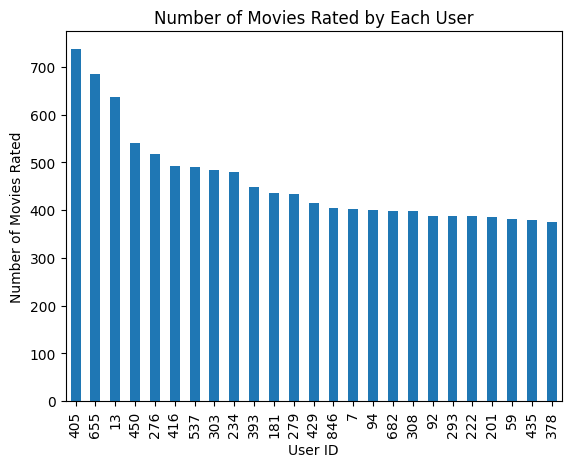

In [17]:
#Step 2
# Basic Descriptive Statistics
# Plot number of movies seen by each user
user_movie_counts = ratings['user_id'].value_counts().head(25)
# head(25) to plot the top 25, because the chart was too crowded, this shows us the top users
plt.figure()
user_movie_counts.plot(kind='bar')
plt.xlabel('User ID')
plt.ylabel('Number of Movies Rated')
plt.title('Number of Movies Rated by Each User')
plt.show()

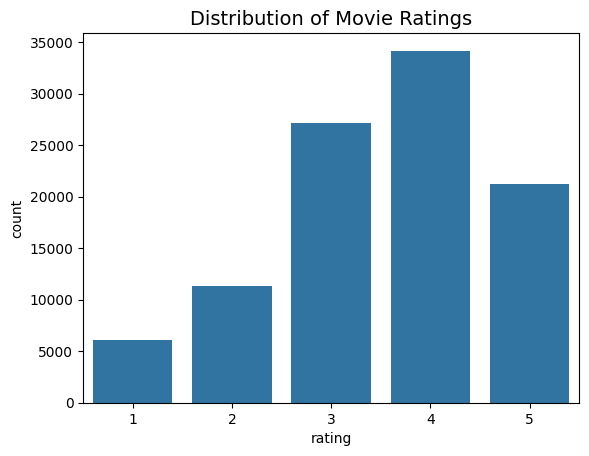

In [18]:
#Let's check the distribution of movie ratings.
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Movie Ratings', fontsize = 14)
plt.show()

In [19]:
#More descriptive statistics of the data sets, to understand the spread of the data further and make an informed decision
#on the outliers

# Mean, median, and standard deviation of movies seen by each user
#count of the number of time each unique user id appears in column 
user_movie_counts = ratings['user_id'].value_counts()
#statistics of the user movie counts
mean_movies_rated = user_movie_counts.mean()
median_movies_rated = user_movie_counts.median()
std_movies_rated = user_movie_counts.std()
Q3_movies_rated = user_movie_counts.quantile(0.75)
# Largest (maximum) number of movies rated by a user
max_movies_rated = user_movie_counts.max()
# Smallest (minimum) number of movies rated by a user
min_movies_rated = user_movie_counts.min()

# Creating a summary table to visualize the results
summary_table = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Top Quartile','Standard Deviation', 'Minimum', 'Maximum'],
    'Movies Rated by User': [mean_movies_rated, median_movies_rated, Q3_movies_rated, std_movies_rated, max_movies_rated, min_movies_rated]
})

# Display the table
print(summary_table.round(1))

from scipy.stats import percentileofscore
#We want to see what percentage of the values are above 1.5 standard deviations of the mean which is 106 + 151.35. round to nearest whole number
value = 257
# Calculate the percentile of this value within the distribution of movie counts
percentile = percentileofscore(user_movie_counts, value, kind='rank')

#####change the print syntax to be simpler
print(f"The percentage of users that have rated less than or equal to 257 movies is: {percentile.round(2)}%")

            Statistic  Movies Rated by User
0                Mean                 106.0
1              Median                  65.0
2        Top Quartile                 148.0
3  Standard Deviation                 100.9
4             Minimum                 737.0
5             Maximum                  20.0
The percentage of users that have rated less than or equal to 257 movies is: 90.67%


In [20]:
#Μean global rating.
print("Mean global rating: %s" %(round(ratings['rating'].mean(), 2)))
#Mean rating per user.
mean_rating = ratings.groupby('user_id')[['rating']].mean()
print("Mean rating per user: %s" %(round(mean_rating.mean(), 2)))

Mean global rating: 3.53
Mean rating per user: rating    3.59
dtype: float64


In [21]:
#More descriptive statistics of the data sets, to understand the spread of the data further and make an informed decision
#on the outliers

# Mean, median, and standard deviation of ratings recieved for each movie
#count of the number of time each movie (item) appears in column 
movie_rating_counts = ratings['item_id'].value_counts()
#statistics of the movie ratings counts
mean_ratings_received = movie_rating_counts.mean()
median_ratings_received = movie_rating_counts.median()
std_ratings_received = movie_rating_counts.std()
Q3_ratings_received = movie_rating_counts.quantile(0.75)
# Largest (maximum) number of ratings for a movie
max_ratings_received = movie_rating_counts.max()
# Smallest (minimum) number of ratings for a movie
min_ratings_received = movie_rating_counts.min()

# Creating a summary table to visualize the results
summary_table2 = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Top Quartile','Standard Deviation', 'Minimum', 'Maximum'],
    'Ratings Received for Each Movie': [mean_ratings_received, median_ratings_received, Q3_ratings_received, std_ratings_received, max_ratings_received, min_ratings_received]
})

# Display the table
print(summary_table2.round(1))

#We want to see what percentage of the values are above 1.5 standard deviations of the mean which is 59.5 + 120.6. round to nearest whole number
value = 180
# Calculate the percentile of this value within the distribution of movie rating counts
percentile2 = percentileofscore(movie_rating_counts, value, kind='rank')

#####change the print syntax to be simpler
print(f"The percentage of movies that have been rated less than or equal to 180 times is: {percentile2.round(2)}%")

# we decide to do 1.5 standard deviations for this dataset as well

            Statistic  Ratings Received for Each Movie
0                Mean                             59.5
1              Median                             27.0
2        Top Quartile                             80.0
3  Standard Deviation                             80.4
4             Minimum                            583.0
5             Maximum                              1.0
The percentage of movies that have been rated less than or equal to 180 times is: 91.8%


##### The most frequently rated movies

In [22]:
#Let's find the most frequently rated movies. In order to to that we need to merge ratings with movies.
# Let's create a common dataset. The common key between ratings and movies is the 'items_id' and ‘movie_id’ column respectively.
# First we have to rename the column.
ratings1 = ratings.copy()
##
#data.drop(['timestamp', 'video_release_date', 'IMDb_URL'], axis = 1, inplace = True)
ratings1.rename(columns={'item_id': 'movie_id'}, inplace=True)
# Then we combined them.
data = pd.merge(ratings1, movies, on = 'movie_id')
# In order to have a 'cleaner' view of our data we dropped some columns.
data.drop(['timestamp', 'video_release_date', 'IMDb_URL'], axis = 1, inplace = True)

#Most rated movies
data['movie_title'].value_counts()[0:10]

movie_title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: count, dtype: int64

##### Statistics only on movies

In [23]:
#Let's make a dataframe with only movies data
movies_data = data.copy()
#datetype=object to date-type.
movies_data['release_date'] = pd.to_datetime(movies_data['release_date'])
#remove genre columns
# In order to have a 'cleaner' view of our data we dropped some columns.
movies_data.drop(['genre_0',  'genre_1','genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8','genre_9','genre_10', 'genre_11','genre_12','genre_13','genre_14','genre_15','genre_16','genre_17','genre_18', 'user_id'],
          axis = 1, inplace = True)

#Let's find mean rating per movie.
mean_rating_per_movie = movies_data.groupby('movie_id').agg({'rating': 'mean'}).reset_index()
mean_rating_per_movie['rating_count'] = mean_rating_per_movie['rating'].count()
#Top ratest movies
top_ratest_movies = mean_rating_per_movie[mean_rating_per_movie.rating > 4.5].sort_values(by='rating',ascending=False)
top_ratest_movies

,movie_id,rating,rating_count
813,814,5.000,1682
1121,1122,5.000,1682
1188,1189,5.000,1682
1200,1201,5.000,1682
1292,1293,5.000,1682
1466,1467,5.000,1682
1499,1500,5.000,1682
1598,1599,5.000,1682
1535,1536,5.000,1682
1652,1653,5.000,1682


In [24]:
#Statistics extras
movies_stats = ratings1.groupby('movie_id')['rating'].agg(['count', 'mean'])

#Let's find Bayesian average to check the highest rated movies based on ratings and the ratings number.
C = movies_stats['count'].mean()
m = movies_stats['mean'].mean()

print("Average number of ratings for a given movie: %s" %(round(C,2)))
print("Average rating for a given movie: %s" %(round(m,2)))

def bayesian_average(ratings):
    bayesian_average = (C+m+ratings.sum())/(C+ratings.count())
    return round(bayesian_average,2)

Average number of ratings for a given movie: 59.45
Average rating for a given movie: 3.08


In [25]:
#using bayesian average to account for the quanity of the ratings along with the rating score
bayesian_average_ratings = ratings1.groupby('movie_id')['rating'].agg(bayesian_average).reset_index()
bayesian_average_ratings.columns = ['movie_id', 'bayesian_avg']
movies_stats = movies_stats.merge(bayesian_average_ratings, on = 'movie_id')

# So Based on the bayesian average the top 10 rated movies are:
movies_stats = movies_stats.merge(movies[['movie_id','movie_title']])
movies_stats.sort_values('bayesian_avg', ascending= False).head(10)

,movie_id,count,mean,bayesian_avg,movie_title
49,50,583,4.358491,4.05,Star Wars (1977)
317,318,298,4.466443,3.90,Schindler's List (1993)
126,127,413,4.283293,3.88,"Godfather, The (1972)"
173,174,420,4.252381,3.86,Raiders of the Lost Ark (1981)
97,98,390,4.289744,3.86,"Silence of the Lambs, The (1991)"
63,64,283,4.445230,3.86,"Shawshank Redemption, The (1994)"
99,100,508,4.155512,3.83,Fargo (1996)
482,483,243,4.456790,3.79,Casablanca (1942)
11,12,267,4.385768,3.78,"Usual Suspects, The (1995)"
312,313,350,4.245714,3.78,Titanic (1997)


In [26]:
# Based on the bayesian average the 10 least rated movies are:
movies_stats = movies_stats.merge(movies[['movie_id','movie_title']])
movies_stats.sort_values('bayesian_avg', ascending= True).head(10)

,movie_id,count,mean,bayesian_avg,movie_title
1677,1678,1,1.0,1.05,Mat' i syn (1997)
1670,1671,1,1.0,1.05,"Further Gesture, A (1996)"
1545,1546,1,1.0,1.05,Shadows (Cienie) (1988)
1582,1583,1,1.0,1.05,"Invitation, The (Zaproszenie) (1986)"
1581,1582,1,1.0,1.05,T-Men (1947)
1580,1581,1,1.0,1.05,"Woman in Question, The (1950)"
1579,1580,1,1.0,1.05,Liebelei (1933)
1578,1579,1,1.0,1.05,Baton Rouge (1988)
1547,1548,1,1.0,1.05,The Courtyard (1995)
1564,1565,1,1.0,1.05,Daens (1992)


##### Outliers

In [ ]:
# Outlier Detection for Users and Movies with a 1.5 Standard Deviation Threshold
# choosing 1.5 for the outlier threshold because ~91% of users are concentrated below 1.5 standard deviation of the mean.

#We have user_movie_counts as data of how many movies each user has rated
# Step 1: Calculate the number of ratings each movie has received
movie_rating_counts = ratings['item_id'].value_counts()

# Step 3: Calculate z-scores for user and movie counts to detect outliers
user_movie_counts_zscore = zscore(user_movie_counts)
movie_rating_counts_zscore = zscore(movie_rating_counts)

# Step 4: Set a threshold of 1.5 standard deviations for detecting outliers
outlier_user_indices = user_movie_counts[user_movie_counts_zscore > 1.5].index
outlier_movie_indices = movie_rating_counts[movie_rating_counts_zscore > 1.5].index

# Outlier users: those who have rated more than 1.5 standard deviations above the mean aka more than ~257 movies or a movie with more than ~180
outlier_users = user_movie_counts[user_movie_counts_zscore > 1.5]
#print("Outlier users based on number of ratings (Threshold = 1.5 SD):")
#print(outlier_users)

# Outlier movies: those that have received more than 1.5 standard deviations above the mean
outlier_movies = movie_rating_counts[(movie_rating_counts_zscore > 1.5)
print("\nOutlier movies based on number of ratings (Threshold > +-1.5 SD):")
outlier_movies


Outlier movies based on number of ratings (Threshold <> +-1.5 SD):


item_id
50     583
258    509
100    508
181    507
294    485
      ... 
203    182
23     182
732    180
514    180
751    180
Name: count, Length: 140, dtype: int64

In [28]:
# Check numerical columns
num_cols = movies_stats.describe(exclude='object') #check numerical columns only
col_names = num_cols.columns # we are using these numerical columns for visualizing our boxplot

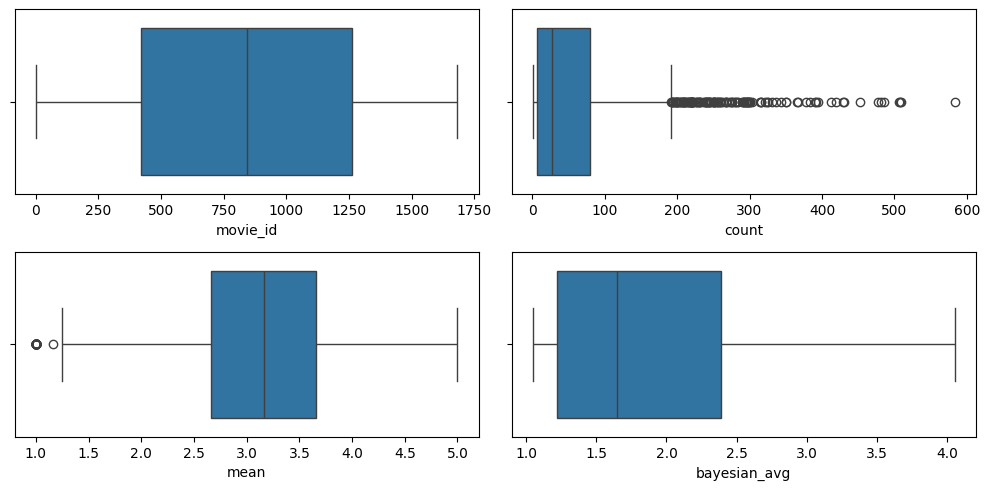

In [29]:
# Let's plot the outliers for movies_stats
# Boxplot for the first 6 values taking into consideration movies_stats
fig = plt.figure(figsize=(10,7))

for i in range(4): #for 4 columns
    fig.tight_layout()
    
    grid_col = "32{}".format(i+1)
    
    ax = fig.add_subplot(int(grid_col))
    
    sns.boxplot(data=movies_stats, x=col_names[i], ax=ax)
    
plt.show()

##### User-Item Matrix

In [30]:
# Convert the data to a user-item matrix format
user_movie_ratings_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')

# Display the user-item matrix
print("User-Movie Matrix:")
print(user_movie_ratings_matrix.head(15))

# Save the user-item matrix to a CSV file to investigate if it was correct
user_movie_ratings_matrix.to_csv('user_movie_ratings_matrix.csv')


User-Movie Matrix:
item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5         4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
6         4.0   NaN   NaN   NaN   NaN   NaN   2.0   4.0   4.0   NaN  ...   
7         NaN   NaN   NaN   5.0   NaN   NaN   5.0   5.0   5.0   4.0  ...   
8         NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN   NaN   NaN  ...   
9         NaN   NaN   NaN   NaN   NaN   5.0   4.0   NaN   NaN   NaN  ...   
10        4.0   NaN   NaN   4.0   NaN   NaN   4.0   NaN   4.0   NaN  ...   
11        NaN   NaN   NaN   NaN   NaN   NaN   NaN   4.0   5.0   NaN  

In [31]:
# Matrix preparation 
#Because the similarity computation requires complete data we replace all the missing values with zeros.
#Report - consine similarity- Να κάνουμε έρευνα για το ότι πρέπει να υπάρχει similarity στα κελιά των δεδομένων μας και επεξήγηση.
ratings_matrix_filled = user_movie_ratings_matrix.fillna(0)

In [32]:
#Let's see the number of rows and columns in our matrix.
ratings_matrix_filled.shape

(943, 1682)

In [33]:
#Let's evaluate our matrix. We will calculate sparsity.
n_total = ratings_matrix_filled.shape[0] * ratings_matrix_filled.shape[1] #total number of cells
n_ratings = np.count_nonzero(ratings_matrix_filled)
sparsity = n_ratings/n_total
print("Matrix sparsity: %s" %(round(sparsity,2)))

Matrix sparsity: 0.06


In [34]:
n_ratings_per_user = np.count_nonzero(ratings_matrix_filled, axis=1)
len(n_ratings_per_user)

943

In [35]:
n_ratings_per_movie = np.count_nonzero(ratings_matrix_filled, axis=0)
len(n_ratings_per_movie)

1682

##### Most active vs least active users

In [36]:
#Let's find the most active and the less active users.
print("Most active users rated %s movies" %(n_ratings_per_user.max()))
print("Least active users rated %s movies" %(n_ratings_per_user.min()))

Most active users rated 737 movies
Least active users rated 20 movies


##### Most rated movie vs least rated movie

In [37]:
#Let's find the most rated and the rated movies.
print("Most rated movie has %s ratings" %(n_ratings_per_movie.max()))
print("Least rated movie has %s ratings" %(n_ratings_per_movie.min()))

Most rated movie has 583 ratings
Least rated movie has 1 ratings


/tmp/ipykernel_6070/2023510543.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
/tmp/ipykernel_6070/2023510543.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie, shade=True)


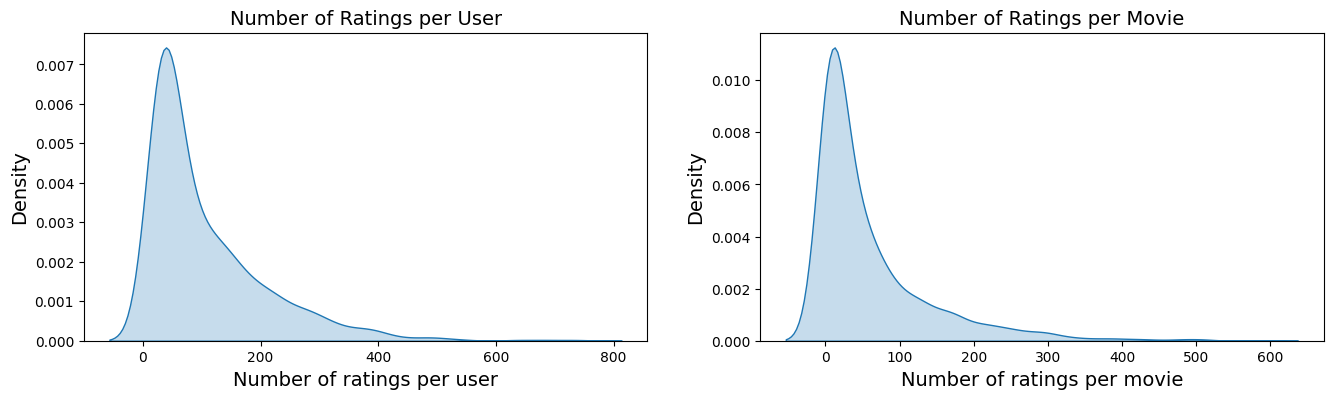

In [38]:
#Let's make graphs
plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.title('Number of Ratings per User', fontsize=14)
plt.xlabel('Number of ratings per user', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.title('Number of Ratings per Movie', fontsize=14)
plt.xlabel('Number of ratings per movie', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

### Q2: Basic Recommender System

#### User Split and top 5 recommendations of the train set

In [39]:
# Split users into train and test set
test_df = users.sample(frac=0.2, random_state=42)
train_df = users.drop(test_df.index)

# Find users only in train set
train_users = train_df["user_id"]
train_ratings = ratings[ratings["user_id"].isin(train_users)]

# Calculate the average rating for each movie rated by users in the train set:
avg_ratings = (train_ratings.groupby("item_id")["rating"].mean().reset_index(name="avg_rating"))

# Calculate the how many ratings each movie from the train set received:
rating_counts = (train_ratings.groupby("item_id").size().reset_index(name="rating_count"))

# Merge average ratings and rating counts to calculate and display weighted average:
movie_stats = pd.merge(avg_ratings, rating_counts, on="item_id")

# Calculate the weighted average for each movie:
movie_stats["weighted_average"] = (movie_stats["avg_rating"]*movie_stats["rating_count"])/movie_stats["rating_count"].sum()

# Sort by the weighted average and take the top 10 movies
top_weighted_movies = movie_stats.sort_values(by="weighted_average", ascending=False).head(5)

# Hide the 'weighted_average' column by dropping when displaying for presentation purposes:
top_weighted_movies_to_display = top_weighted_movies

# Match movie id with movie name from movies dataset:
top_movies_with_titles = pd.merge(top_weighted_movies, movies_cleaned, left_on="item_id", right_on="movie_id")

# Display the results
print("Top movies to recommend to test users based on train set users' preferences:")
print(top_movies_with_titles[["movie_title", "avg_rating", "rating_count","weighted_average","Movie genre"]])

Top movies to recommend to test users based on train set users' preferences:
                      movie_title  avg_rating  rating_count  weighted_average  \
0                Star Wars (1977)    4.342612           467          0.025253   
1                    Fargo (1996)    4.167076           407          0.021119   
2       Return of the Jedi (1983)    3.992701           411          0.020434   
3                  Contact (1997)    3.802439           410          0.019413   
4  Raiders of the Lost Ark (1981)    4.270030           337          0.017919   

                               Movie genre  
0  Action, Adventure, Romance, Sci-Fi, War  
1                   Crime, Drama, Thriller  
2  Action, Adventure, Romance, Sci-Fi, War  
3                            Drama, Sci-Fi  
4                        Action, Adventure  


##### Random selection

In [40]:
np.random.seed(42)
# Recommend 10 movies at random from the training ratings
random_indices = np.random.randint(0, len(train_ratings), size=5)
random_rows = train_ratings.iloc[random_indices]  # Select random rows

# Merge the random movies with the movies dataset to include movie titles
random_movies_with_titles = pd.merge(random_rows, movies_cleaned, left_on="item_id",right_on="movie_id")

# Display the results
print("5 Randomly Recommended Movies from Train Set:")
print(random_movies_with_titles[["movie_title", "rating","Movie genre"]])

5 Randomly Recommended Movies from Train Set:
                       movie_title  rating                  Movie genre
0  Clear and Present Danger (1994)       4  Action, Adventure, Thriller
1                GoodFellas (1990)       5                 Crime, Drama
2                    Scream (1996)       3             Horror, Thriller
3                   Sabrina (1954)       4              Comedy, Romance
4                 Manhattan (1979)       5       Comedy, Drama, Romance


In [41]:
# Rename 'avg_rating' column to 'rating'
top_weighted_movies.rename(columns={'avg_rating': 'rating'}, inplace=True)
top_weighted_movies = top_weighted_movies.drop(columns=['rating_count', 'weighted_average'])

# Convert to DataFrame
top_weighted_movies = pd.DataFrame(top_weighted_movies)
top_weighted_movies = top_weighted_movies.reset_index(drop=True)


##### Evaluation

In [42]:
# Threshold for considering a test user to consider a movie as "relevant":
RELEVANCE_THRESHOLD = 3

# Isolate the user ids from the test set into a separate series:
test_users = test_df["user_id"]

# Create initial lists that are empty:
precision_list = []
recall_list = []
f1_list = []

for user_id in test_users:
    # Test user ratings and movies rated as relevant by the user in the test set
    user_test_ratings = ratings[(ratings["user_id"] == user_id) & (ratings["rating"] >= RELEVANCE_THRESHOLD)]
    # Isolate movie id into a separate set to be used for calculations
    relevant_movies = set(user_test_ratings["item_id"])
    # Top 5 recommendations based on weighted average to a list
    top_recommendations = top_movies_with_titles["item_id"].tolist()
    # Random 5 recommendations to a list
    random_recommendations = random_movies_with_titles["item_id"].tolist()
    
    # Combine both lists into one and label them accordingly
    for recommendations, version in zip([top_recommendations, random_recommendations], ["top-rated", "random"]):
        #Converts the list of recommended movies into a set for use of intersection method:
        recommended_set = set(recommendations)
        # Identifies movies that are both recommended and above the relevance threshold for the test user:
        relevant_recommended = recommended_set.intersection(relevant_movies)
        
        # Calculate precision, recall, and F1 and avoid division by 0 error
        precision = len(relevant_recommended) / len(recommended_set) if len(recommended_set) > 0 else 0
        recall = len(relevant_recommended) / len(relevant_movies) if len(relevant_movies) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Store metrics to then convert to a dataframe
        precision_list.append((user_id, version, precision))
        recall_list.append((user_id, version, recall))
        f1_list.append((user_id, version, f1))

# Convert results to dataFrame for clarity
precision_df = pd.DataFrame(precision_list, columns=["user_id", "version", "precision"])
recall_df = pd.DataFrame(recall_list, columns=["user_id", "version", "recall"])
f1_df = pd.DataFrame(f1_list, columns=["user_id", "version", "f1"])

# Optionally print to csv:
# precision_df.to_csv("precision_results.csv", index=False)
# recall_df.to_csv("recall_results.csv", index=False)
# f1_df.to_csv("f1_results.csv", index=False)

# Display aggregated results
print("Precision percentage (%):")
print(precision_df.groupby("version")["precision"].mean()*100)
print("\nRecall percentage (%):")
print(recall_df.groupby("version")["recall"].mean()*100)
print("\nF1:")
print(f1_df.groupby("version")["f1"].mean())

Precision percentage (%):
version
random       18.624339
top-rated    48.465608
Name: precision, dtype: float64

Recall percentage (%):
version
random       1.470213
top-rated    3.952562
Name: recall, dtype: float64

F1:
version
random       0.025478
top-rated    0.069671
Name: f1, dtype: float64


### Q3: Collaborative Filtering - Recommender system

In [43]:
# Compute cosine similarity between users
similar_users = cosine_similarity(ratings_matrix_filled)
#Turn it to dataframe
similar_users = pd.DataFrame(similar_users, index=ratings_matrix_filled.index, columns = ratings_matrix_filled.index)

# Cosine similarity sanity check. All similarities should be lower than one:
any_value_greater_than_one = (similar_users.iloc[:, 1:] > 1.00000000000001).any().any()
if any_value_greater_than_one == np.False_:
    print("No values greater than one, cosine similarity is correct")
else:
    print("Cosine similarity logical failure. All values should be below 1. Most likely a rounding error.")
similar_users

No values greater than one, cosine similarity is correct


user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.166931,0.047460,0.064358,0.378475,0.430239,0.440367,0.319072,0.078138,0.376544,...,0.369527,0.119482,0.274876,0.189705,0.197326,0.118095,0.314072,0.148617,0.179508,0.398175
2,0.166931,1.000000,0.110591,0.178121,0.072979,0.245843,0.107328,0.103344,0.161048,0.159862,...,0.156986,0.307942,0.358789,0.424046,0.319889,0.228583,0.226790,0.161485,0.172268,0.105798
3,0.047460,0.110591,1.000000,0.344151,0.021245,0.072415,0.066137,0.083060,0.061040,0.065151,...,0.031875,0.042753,0.163829,0.069038,0.124245,0.026271,0.161890,0.101243,0.133416,0.026556
4,0.064358,0.178121,0.344151,1.000000,0.031804,0.068044,0.091230,0.188060,0.101284,0.060859,...,0.052107,0.036784,0.133115,0.193471,0.146058,0.030138,0.196858,0.152041,0.170086,0.058752
5,0.378475,0.072979,0.021245,0.031804,1.000000,0.237286,0.373600,0.248930,0.056847,0.201427,...,0.338794,0.080580,0.094924,0.079779,0.148607,0.071459,0.239955,0.139595,0.152497,0.313941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.118095,0.228583,0.026271,0.030138,0.071459,0.111852,0.107027,0.095898,0.039852,0.071460,...,0.066039,0.431154,0.258021,0.226449,0.432666,1.000000,0.087687,0.180029,0.043264,0.144250
940,0.314072,0.226790,0.161890,0.196858,0.239955,0.352449,0.329925,0.246883,0.120495,0.342961,...,0.327153,0.107024,0.187536,0.181317,0.175158,0.087687,1.000000,0.145152,0.261376,0.241028
941,0.148617,0.161485,0.101243,0.152041,0.139595,0.144446,0.059993,0.146145,0.143245,0.090305,...,0.046952,0.203301,0.288318,0.234211,0.313400,0.180029,0.145152,1.000000,0.101642,0.095120


##### Calculate similarities between users based on their ratings

##### Top 5 similar users for each user

In [44]:
# Find the top 5 similar users for each user.
nUsers=ratings_matrix_filled.shape[0] # total number of users
r = ratings_matrix_filled
k= similar_users

nUsers=ratings_matrix_filled.shape[0] # total number of users
nItems=ratings_matrix_filled.shape[1] # total number of items
r = ratings_matrix_filled.values

nRows=r.shape[0]
nCols=r.shape[1]
similarUsers, similarities=findKSimilar (r,5) # top 5 similar users for each user

[267 863 915   0] 0
[267 863 915   0] 1
[267 863 915   0] 2
[267 863 915   0] 3
[267 863 915   0] 4
[459 930 700   1] 0
[459 930 700   1] 1
[459 930 700   1] 2
[459 930 700   1] 3
[459 930 700   1] 4
[615 488 862   2] 0
[615 488 862   2] 1
[615 488 862   2] 2
[615 488 862   2] 3
[615 488 862   2] 4
[569 450 749   3] 0
[569 450 749   3] 1
[569 450 749   3] 2
[569 450 749   3] 3
[569 450 749   3] 4
[406 647 306   4] 0
[406 647 306   4] 1
[406 647 306   4] 2
[406 647 306   4] 3
[406 647 306   4] 4
[536  17 473   5] 0
[536  17 473   5] 1
[536  17 473   5] 2
[536  17 473   5] 3
[536  17 473   5] 4
[405 312 649   6] 0
[405 312 649   6] 1
[405 312 649   6] 2
[405 312 649   6] 3
[405 312 649   6] 4
[825 196 599   7] 0
[825 196 599   7] 1
[825 196 599   7] 2
[825 196 599   7] 3
[825 196 599   7] 4
[432 796 734   8] 0
[432 796 734   8] 1
[432 796 734   8] 2
[432 796 734   8] 3
[432 796 734   8] 4
[233   5 473   9] 0
[233   5 473   9] 1
[233   5 473   9] 2
[233   5 473   9] 3
[233   5 473   9] 4


[ 38 811 684  35] 0
[ 38 811 684  35] 1
[ 38 811 684  35] 2
[ 38 811 684  35] 3
[ 38 811 684  35] 4
[618 745 216  36] 0
[618 745 216  36] 1
[618 745 216  36] 2
[618 745 216  36] 3
[618 745 216  36] 4
[896 619 641  37] 0
[896 619 641  37] 1
[896 619 641  37] 2
[896 619 641  37] 3
[896 619 641  37] 4
[283 104 407  38] 0
[283 104 407  38] 1
[283 104 407  38] 2
[283 104 407  38] 3
[283 104 407  38] 4
[914 148 573  39] 0
[914 148 573  39] 1
[914 148 573  39] 2
[914 148 573  39] 3
[914 148 573  39] 4
[ 95 737  76  40] 0
[ 95 737  76  40] 1
[ 95 737  76  40] 2
[ 95 737  76  40] 3
[ 95 737  76  40] 4
[310 863 576  41] 0
[310 863 576  41] 1
[310 863 576  41] 2
[310 863 576  41] 3
[310 863 576  41] 4
[863 377 653  42] 0
[863 377 653  42] 1
[863 377 653  42] 2
[863 377 653  42] 3
[863 377 653  42] 4
[863 803 737  43] 0
[863 803 737  43] 1
[863 803 737  43] 2
[863 803 737  43] 3
[863 803 737  43] 4
[937 100 702  44] 0
[937 100 702  44] 1
[937 100 702  44] 2
[937 100 702  44] 3
[937 100 702  44] 4


##### 5 similar users of user 10

In [45]:
# Let's check if user 10 is in rows of similarUsers and their 5 similar users.
user_id = 10
if user_id < similarUsers.shape[0]:
    print(f"Similar users for user {user_id}: {similarUsers[user_id]}")
else:
    print(f"User {user_id} is out of range. There are only {similarUsers.shape[0]} users.")

Similar users for user 10: [270.  93. 377.  58. 449.]


##### Prediction vs real value

In [46]:
# Let's see the prediction of our recommender system vs the real value for user 4 on item 1.
userId=4
itemId=1
prediction=predict(userId,itemId,r, similarUsers, similarities)
print ('The prediction for user 4 on item 1, based on collaborative filtering, would be', round(prediction,2), ', while the real value is', round(r[userId,itemId],2))

The prediction for user 4 on item 1, based on collaborative filtering, would be 2.2 , while the real value is 3.0


##### Hide 20% and start over

In [47]:
# Switch the ratings matrix dataframe to a numpy array to allow for processing:
matrix_np = ratings_matrix_filled.values
# Create the train and test matrices by masking 20% of the ratings
train_matrix, test_matrix = mask_matrix(matrix_np, test_size=0.2)


##### Predictions

In [48]:
# Calculate user-user cosine similarity
user_similarity = cosine_similarity(train_matrix)
# Generate the predicted matrix to be used for evaluation with k=5
predicted_matrix = predict_ratings(train_matrix, user_similarity, k=5)

##### Evaluate the predictions

In [49]:

#Evaluate the predicted ratings against the test matrix
mae, rmse, precision, recall, f1 = evaluate(test_matrix, predicted_matrix, k=5)
evaluation_metrics_df = pd.DataFrame({"k": [5],"MAE": [mae],"RMSE": [rmse],"Precision": [precision],"Recall": [recall],"F1 Score": [f1]})
evaluation_metrics_df



,k,MAE,RMSE,Precision,Recall,F1 Score
0,5,2.170923,2.503773,0.102114,0.136814,0.116944



### Q4: Improvements

##### Tune Hyperparameters

In [50]:
adjustment_results = []
for k in [3, 5, 10, 20]:  # Different values of k
    # Call predict_ratings function and allow for k iteration
    predicted_matrix = predict_ratings(train_matrix, user_similarity, k=k)
    # Call evaluate function to calculate evaluation metrics
    mae, rmse, precision, recall, f1 = evaluate(test_matrix, predicted_matrix, k=5)
    # Return results as dataframe
    adjustment_results.append((k, mae, rmse, precision, recall, f1))

# Call the function and store results in a dataframe
hyperparameter_adjustment_results = pd.DataFrame(adjustment_results, columns=['k', 'MAE', 'RMSE', 'Precision', 'Recall', 'F1'])

# Display dataframe
print("Hyperparameter tuning results for number of neighbors k=[3,5,10,20]:")
hyperparameter_adjustment_results

Hyperparameter tuning results for number of neighbors k=[3,5,10,20]:


,k,MAE,RMSE,Precision,Recall,F1
0,3,2.207197,2.576381,0.096337,0.169078,0.122740
1,5,2.170923,2.503773,0.102114,0.136814,0.116944
2,10,2.162577,2.463503,0.104682,0.099809,0.102187
3,20,2.187146,2.466710,0.109920,0.074503,0.088811


In [51]:
# Optimize hyperparameters
optimization_results = []
for k in range(5, 151):  # Different values of k
    # Call predict_ratings function and allow for k iteration
    predicted_matrix = predict_ratings(train_matrix, user_similarity, k=k)
    # Call evaluate function to calculate evaluation metrics
    mae, rmse, precision, recall, f1 = evaluate(test_matrix, predicted_matrix, k=5)
    # Append results to the list
    optimization_results.append((k, mae, rmse, precision, recall, f1))
# Convert the results to a DataFrame
hyperparameter_optimization_results = pd.DataFrame(optimization_results, columns=['k', 'MAE', 'RMSE', 'Precision', 'Recall', 'F1'])

# Find the optimal k with the lowest RMSE
optimal_k_row_RMSE = hyperparameter_optimization_results.loc[hyperparameter_optimization_results['RMSE'].idxmin()]
optimal_k_row_MAE = hyperparameter_optimization_results.loc[hyperparameter_optimization_results['MAE'].idxmin()]
optimal_k_row_precision = hyperparameter_optimization_results.loc[hyperparameter_optimization_results['Precision'].idxmax()]
optimal_k_row_recall = hyperparameter_optimization_results.loc[hyperparameter_optimization_results['Recall'].idxmax()]
optimal_k_row_f1 = hyperparameter_optimization_results.loc[hyperparameter_optimization_results['F1'].idxmax()]

# # (Optional) Save the results to a CSV file
# hyperparameter_optimization_results.to_csv("hyperparameter_optimization_results.csv", index=False)

# Display the optimal k
print(f"The optimal number of neighbors (k) based on the lowest RMSE is: {optimal_k_row_RMSE}")
print(f"The optimal number of neighbors (k) based on the lowest MAE is: {optimal_k_row_MAE}")
print(f"The optimal number of neighbors (k) based on the highest precision is: {optimal_k_row_precision}")
print(f"The optimal number of neighbors (k) based on the highest recall is: {optimal_k_row_recall}")
print(f"The optimal number of neighbors (k) based on the highest f1 is: {optimal_k_row_f1}")

# Display the results
print("Hyperparameter optimization results for number of neighbors k between 5 and 150:")
hyperparameter_optimization_results


The optimal number of neighbors (k) based on the lowest RMSE is: k            12.000000
MAE           2.166713
RMSE          2.461777
Precision     0.106061
Recall        0.092667
F1            0.098912
Name: 7, dtype: float64
The optimal number of neighbors (k) based on the lowest MAE is: k            10.000000
MAE           2.162577
RMSE          2.463503
Precision     0.104682
Recall        0.099809
F1            0.102187
Name: 5, dtype: float64
The optimal number of neighbors (k) based on the highest precision is: k            150.000000
MAE            2.387206
RMSE           2.628053
Precision      0.117357
Recall         0.017610
F1             0.030624
Name: 145, dtype: float64
The optimal number of neighbors (k) based on the highest recall is: k            5.000000
MAE          2.170923
RMSE         2.503773
Precision    0.102114
Recall       0.136814
F1           0.116944
Name: 0, dtype: float64
The optimal number of neighbors (k) based on the highest f1 is: k            5.000

,k,MAE,RMSE,Precision,Recall,F1
0,5,2.170923,2.503773,0.102114,0.136814,0.116944
1,6,2.166254,2.489258,0.103555,0.127147,0.114145
2,7,2.165421,2.480331,0.103626,0.117911,0.110308
3,8,2.162938,2.472541,0.103903,0.110153,0.106937
4,9,2.163823,2.468229,0.104757,0.105228,0.104992
...,...,...,...,...,...,...
141,146,2.382422,2.623726,0.115994,0.018041,0.031225
142,147,2.383533,2.624749,0.117060,0.018041,0.031263
143,148,2.384783,2.625871,0.115323,0.017610,0.030554
144,149,2.386037,2.627008,0.117047,0.017671,0.030707


##### User Thresholds

In [52]:
# Calculate user counts
user_counts = ratings['user_id'].value_counts()

# Filter users with at least 50 ratings
active_users = user_counts[user_counts >= 50].index
filtered_data = ratings[ratings['user_id'].isin(active_users)]

# Create a user-item matrix
filtered_user_item_matrix = filtered_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Split the data into train and test matrices
train_matrix_filtered, test_matrix_filtered = mask_matrix(filtered_user_item_matrix.values, test_size=0.2,random_state=42)

# Compute user similarity using cosine similarity
filtered_user_similarity = cosine_similarity(train_matrix_filtered)

# Predict ratings using collaborative filtering
filtered_predicted_matrix = predict_ratings(train_matrix_filtered, filtered_user_similarity, k=5)

# Evaluate the predictions
filtered_mae, filtered_rmse, filtered_precision, filtered_recall, filtered_f1 = evaluate(test_matrix_filtered, filtered_predicted_matrix, k=5)

results_df_50 = pd.DataFrame({"Threshold": [50],"MAE": [filtered_mae], "RMSE": [filtered_rmse],"Precision": [filtered_precision],"Recall": [filtered_recall],"F1 Score": [filtered_f1]})
results_df_50

,Threshold,MAE,RMSE,Precision,Recall,F1 Score
0,50,2.07332,2.409151,0.108487,0.15784,0.128591


In [53]:
# Calculate user counts
user_counts = ratings['user_id'].value_counts()

# Filter users with at least 100 ratings
active_users = user_counts[user_counts >= 100].index
filtered_data = ratings[ratings['user_id'].isin(active_users)]

# Create a user-item matrix
filtered_user_item_matrix = filtered_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Split the data into train and test matrices
train_matrix_filtered, test_matrix_filtered = mask_matrix(filtered_user_item_matrix.values, test_size=0.2,random_state=42)

# Compute user similarity using cosine similarity
filtered_user_similarity = cosine_similarity(train_matrix_filtered)

# Predict ratings using collaborative filtering
filtered_predicted_matrix = predict_ratings(train_matrix_filtered, filtered_user_similarity, k=5)

# Evaluate the predictions
filtered_mae, filtered_rmse, filtered_precision, filtered_recall, filtered_f1 = evaluate(test_matrix_filtered, filtered_predicted_matrix, k=5)

results_df_100 = pd.DataFrame({"Threshold": [100],"MAE": [filtered_mae], "RMSE": [filtered_rmse],"Precision": [filtered_precision],"Recall": [filtered_recall],"F1 Score": [filtered_f1]})
results_df_100

,Threshold,MAE,RMSE,Precision,Recall,F1 Score
0,100,2.007601,2.338324,0.10898,0.160126,0.129693


In [54]:
# Calculate user counts
user_counts = ratings['user_id'].value_counts()

# Filter users with at least 200 ratings
active_users = user_counts[user_counts >= 200].index
filtered_data = ratings[ratings['user_id'].isin(active_users)]

# Create a user-item matrix
filtered_user_item_matrix = filtered_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Split the data into train and test matrices
train_matrix_filtered, test_matrix_filtered = mask_matrix(filtered_user_item_matrix.values, test_size=0.2,random_state=42)

# Compute user similarity using cosine similarity
filtered_user_similarity = cosine_similarity(train_matrix_filtered)

# Predict ratings using collaborative filtering
filtered_predicted_matrix = predict_ratings(train_matrix_filtered, filtered_user_similarity, k=5)

# Evaluate the predictions
filtered_mae, filtered_rmse, filtered_precision, filtered_recall, filtered_f1 = evaluate(test_matrix_filtered, filtered_predicted_matrix, k=5)

results_df_200 = pd.DataFrame({"Threshold": [200],"MAE": [filtered_mae], "RMSE": [filtered_rmse],"Precision": [filtered_precision],"Recall": [filtered_recall],"F1 Score": [filtered_f1]})
results_df_200

,Threshold,MAE,RMSE,Precision,Recall,F1 Score
0,200,1.923009,2.25936,0.121399,0.176546,0.143869


In [55]:
# Combine the three results dataframes into one for comparison
aggregate_results_df = pd.concat([results_df_50, results_df_100, results_df_200], ignore_index=True)

print("Comparison of Evaluation Metrics for Different Thresholds:")
aggregate_results_df

Comparison of Evaluation Metrics for Different Thresholds:


,Threshold,MAE,RMSE,Precision,Recall,F1 Score
0,50,2.073320,2.409151,0.108487,0.157840,0.128591
1,100,2.007601,2.338324,0.108980,0.160126,0.129693
2,200,1.923009,2.259360,0.121399,0.176546,0.143869


In [56]:
# Initialize an empty DataFrame to store results
results = []

# Iterate over thresholds from 1 to 200
for threshold in range(1, 201):
    # Calculate user counts
    user_counts = ratings['user_id'].value_counts()

    # Filter users with at least 'threshold' ratings
    active_users = user_counts[user_counts >= threshold].index
    filtered_data = ratings[ratings['user_id'].isin(active_users)]

    # Create a user-item matrix
    filtered_user_item_matrix = filtered_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

    # Skip iteration if matrix is empty after filtering to account that 
    if filtered_user_item_matrix.empty:
        continue

    # Split the data into train and test matrices
    train_matrix_filtered, test_matrix_filtered = mask_matrix(filtered_user_item_matrix.values, test_size=0.2, random_state=42)

    # Compute user similarity using cosine similarity
    filtered_user_similarity = cosine_similarity(train_matrix_filtered)

    # Predict ratings using collaborative filtering
    filtered_predicted_matrix = predict_ratings(train_matrix_filtered, filtered_user_similarity, k=5)

    # Evaluate the predictions
    filtered_mae, filtered_rmse, filtered_precision, filtered_recall, filtered_f1 = evaluate(test_matrix_filtered, filtered_predicted_matrix, k=5)

    # Append results for the current threshold
    results.append({"Threshold": threshold,"MAE": filtered_mae,"RMSE": filtered_rmse,"Precision": filtered_precision,"Recall": filtered_recall,"F1 Score": filtered_f1,})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Find the threshold with the minimum RMSE
optimal_threshold = results_df['RMSE'].idxmin()
optimal_threshold_value = results_df.loc[optimal_threshold, 'Threshold']
optimal_RMSE = results_df.loc[optimal_threshold, 'RMSE']

# Display the results DataFrame and the minimum RMSE threshold
print(results_df)
print(f"Threshold with minimum RMSE: {optimal_threshold_value}, RMSE: {optimal_RMSE}")


     Threshold       MAE      RMSE  Precision    Recall  F1 Score
0            1  2.170923  2.503773   0.102114  0.136814  0.116944
1            2  2.170923  2.503773   0.102114  0.136814  0.116944
2            3  2.170923  2.503773   0.102114  0.136814  0.116944
3            4  2.170923  2.503773   0.102114  0.136814  0.116944
4            5  2.170923  2.503773   0.102114  0.136814  0.116944
..         ...       ...       ...        ...       ...       ...
195        196  1.919165  2.251864   0.121397  0.181440  0.145467
196        197  1.910191  2.245517   0.124560  0.183708  0.148459
197        198  1.927442  2.260469   0.126054  0.183228  0.149357
198        199  1.927442  2.260469   0.126054  0.183228  0.149357
199        200  1.923009  2.259360   0.121399  0.176546  0.143869

[200 rows x 6 columns]
Threshold with minimum RMSE: 197, RMSE: 2.2455166885061963


##### Additional Features

#### Age

In [57]:
# Normalize the age column in the users dataset to be between 0 and 1. Formula is :(value-minimum value)/(max value - min value)
users['normalized_age'] = (users['age'] - users['age'].min()) / (users['age'].max() - users['age'].min())

# Create a new similarity matrix based on the normalized 'age' values
age_similarity = cosine_similarity(users[['normalized_age']])

# Combine the age similarity with the existing user cosine similarity based on ratings:
# Assign 15% weight to the age similarity and 85% to the original similarity matrix
hybrid_similarity = 0.15 * age_similarity + 0.85 * similar_users

# Cosine similarity sanity check. All similarities should be lower than one:
any_value_greater_than_one_hybrid = (hybrid_similarity.iloc[:, 1:] > 1.00000000000001).any().any()
if any_value_greater_than_one_hybrid == np.False_:
    print("No values greater than one, cosine similarity is correct")
else:
    print("Cosine similarity logical failure. All values should be below 1. Most likely a rounding error.")
hybrid_similarity

No values greater than one, cosine similarity is correct


user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.291891,0.190341,0.204704,0.471704,0.515704,0.524312,0.421211,0.216418,0.470062,...,0.464098,0.251560,0.383645,0.311249,0.317727,0.250381,0.416961,0.276324,0.302582,0.488449
2,0.291891,1.000000,0.244003,0.301403,0.212032,0.358967,0.241229,0.237843,0.286890,0.285883,...,0.283438,0.411751,0.454971,0.510439,0.421905,0.344296,0.342771,0.287262,0.296428,0.239928
3,0.190341,0.244003,1.000000,0.442528,0.168058,0.211553,0.206216,0.220601,0.201884,0.205378,...,0.177094,0.186340,0.289255,0.208683,0.255609,0.172331,0.287607,0.236056,0.263404,0.172572
4,0.204704,0.301403,0.442528,1.000000,0.177034,0.207838,0.227546,0.309851,0.236091,0.201730,...,0.194291,0.181266,0.263147,0.314450,0.274150,0.175617,0.317329,0.279235,0.294573,0.199939
5,0.471704,0.212032,0.168058,0.177034,1.000000,0.351694,0.467560,0.361590,0.198320,0.321213,...,0.437975,0.218493,0.230686,0.217813,0.276316,0.210740,0.353961,0.268656,0.279623,0.416850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.250381,0.344296,0.172331,0.175617,0.210740,0.245074,0.240973,0.231513,0.183874,0.210741,...,0.206133,0.516481,0.369317,0.342482,0.517766,1.000000,0.224534,0.303025,0.186775,0.272612
940,0.416961,0.342771,0.287607,0.317329,0.353961,0.449582,0.430437,0.359850,0.252421,0.441517,...,0.428080,0.240970,0.309405,0.304119,0.298885,0.224534,1.000000,0.273379,0.372170,0.354874
941,0.276324,0.287262,0.236056,0.279235,0.268656,0.272779,0.200994,0.274223,0.271758,0.226759,...,0.189910,0.322806,0.395070,0.349080,0.416390,0.303025,0.273379,1.000000,0.236396,0.230852


In [58]:
if isinstance(train_matrix, pd.DataFrame):
    train_matrix = train_matrix.values
if isinstance(hybrid_similarity, pd.DataFrame):
    hybrid_similarity = hybrid_similarity.values

# Check shapes
print(f"train_matrix shape: {train_matrix.shape}")
print(f"hybrid_similarity shape: {hybrid_similarity.shape}")

# Predict ratings
predicted_matrix_hybrid = predict_ratings(train_matrix, hybrid_similarity, k=12)

# Evaluate predictions
mae, rmse, precision, recall, f1 = evaluate(test_matrix, predicted_matrix_hybrid, k=12)

# Create DataFrame for metrics
hybrid_evaluation_metrics_df = pd.DataFrame({"k": [12],"MAE": [mae],"RMSE": [rmse],"Precision": [precision],"Recall": [recall],"F1 Score": [f1]})

hybrid_evaluation_metrics_df

train_matrix shape: (943, 1682)
hybrid_similarity shape: (943, 943)


,k,MAE,RMSE,Precision,Recall,F1 Score
0,12,1.964478,2.265269,0.153718,0.141678,0.147453


In [59]:
# Comparison of evaluation metrics in aggregate dataframe:
combined_evaluation_metrics_df = pd.concat([hybrid_evaluation_metrics_df, evaluation_metrics_df], ignore_index=True)
sparsity = 1.0 - (np.count_nonzero(test_matrix) / test_matrix.size)
# print(f"Test Matrix Sparsity: {sparsity:.2%}")
combined_evaluation_metrics_df

,k,MAE,RMSE,Precision,Recall,F1 Score
0,12,1.964478,2.265269,0.153718,0.141678,0.147453
1,5,2.170923,2.503773,0.102114,0.136814,0.116944


In [60]:
# Initialize results list
results = []

# Iterate over weights for age similarity from 0% to 100% in increments of 5%
for weight in np.arange(0, 1.05, 0.05):  # 0.0, 0.05, ..., 1.0
    # Combine the age similarity and user similarity matrices
    hybrid_similarity = weight * age_similarity + (1 - weight) * similar_users

    # Check shapes and convert to arrays if necessary
    if isinstance(train_matrix, pd.DataFrame):
        train_matrix = train_matrix.values
    if isinstance(hybrid_similarity, pd.DataFrame):
        hybrid_similarity = hybrid_similarity.values

    # Predict ratings
    predicted_matrix_hybrid = predict_ratings(train_matrix, hybrid_similarity, k=12)

    # Evaluate predictions
    mae, rmse, precision, recall, f1 = evaluate(test_matrix, predicted_matrix_hybrid, k=12)

    # Append results
    results.append({"Age_Similarity_Weight": weight,"MAE": mae,"RMSE": rmse,"Precision": precision,"Recall": recall,"F1 Score": f1,})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Identify the optimal weight based on RMSE
optimal_weight_idx = results_df['RMSE'].idxmin()
optimal_weight = results_df.loc[optimal_weight_idx, 'Age_Similarity_Weight']
optimal_rmse = results_df.loc[optimal_weight_idx, 'RMSE']

print(f"Optimal weight for age similarity: {optimal_weight}, RMSE: {optimal_rmse}")


Optimal weight for age similarity: 0.0, RMSE: 2.264448425984437
